# Dispersion Coefficients Near Surfaces

In this tutorial we reproduce the results depicted in Figure 5 from J. Block and S. Scheel "van der Waals interaction potential between Rydberg atoms near surfaces" [Phys. Rev. A 96, 062509 (2017)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.062509). We calculate the van der Waals $C_6$-coefficient between two Rubidium Rydberg atoms that are equidistantly placed in front of a perfect mirror (i.e. in horizontal alignment in front of a perfectly conducting plate). One finds that the relevant length scale is interatomic distance devided by distance from surface and that for decreasing surface distance the $C_6$ coefficient is significantly reduced.

As described in the [introduction](introduction.ipynb), we start our code with some preparations and load the necessary modules. 

In [1]:
%matplotlib inline

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Operating system interfaces
import os

# pairinteraction :-)
from pairinteraction import pireal as pi

# Create cache for matrix elements
if not os.path.exists("./cache"):
    os.makedirs("./cache")
cache = pi.MatrixElementCache("./cache")

The plate lies in the $xy$-plane with the surface at $z = 0$. The atoms lie in the $xz$-plane with $z>0$.

We can set the angle between the interatomic axis and the z-axis `theta` and the center of mass distance from the surface `distance_surface`. `distance_atom` defines the interatomic distances for which the pair potential is plotted. The units of the respective quantities are given as comments.

Be careful: `theta = np.pi/2` corresponds to horizontal alignment of the two atoms with respect to the surface. For different angles, large interatomic distances `distance_atom` might lead to one of the atoms being placed inside the plate. Make sure that `distance_surface` is larger than `distance_atom*np.cos(theta)/2`

In [2]:
theta = np.pi / 2  # rad
distance_atoms = 10  # µm
distance_surface = np.linspace(
    distance_atoms * np.abs(np.cos(theta)) / 2, 2 * distance_atoms, 30
)  # µm

Next we define the state that we are interested in using pairinteraction's `StateOne` class . As shown in Figures 4 and 5 of [Phys. Rev. A 96, 062509 (2017)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.062509) we expect changes of about 50% for the $C_6$ coefficient of the $|69s_{1/2},m_j=1/2;72s_{1/2},m_j=1/2\rangle$ pair state of Rubidium, so this provides a good example. 

We set up the one-atom system using restrictions of energy, main quantum number n and angular momentum l. This is done by means of the `restrict...` functions in `SystemOne`.

In [3]:
state_one1 = pi.StateOne("Rb", 69, 0, 0.5, 0.5)
state_one2 = pi.StateOne("Rb", 72, 0, 0.5, 0.5)

# Set up one-atom system
system_one = pi.SystemOne(state_one1.getSpecies(), cache)
system_one.restrictEnergy(
    min(state_one1.getEnergy(), state_one2.getEnergy()) - 30,
    max(state_one1.getEnergy(), state_one2.getEnergy()) + 30,
)
system_one.restrictN(
    min(state_one1.getN(), state_one2.getN()) - 3,
    max(state_one1.getN(), state_one2.getN()) + 3,
)
system_one.restrictL(
    min(state_one1.getL(), state_one2.getL()) - 1,
    max(state_one1.getL(), state_one2.getL()) + 1,
)

The pair state `state_two` is created from the one atom states `state_one1` and `state_one2` using the `StateTwo` class.

From the previously set up `system_one` we define `system_two` using `SystemTwo` class. This class also contains methods `set..` to set angle, distance, surface distance and to `enableGreenTensor` in order implement a surface.

In [4]:
# Set up pair state
state_two = pi.StateTwo(state_one1, state_one2)

# Set up two-atom system
system_two = pi.SystemTwo(system_one, system_one, cache)
system_two.restrictEnergy(state_two.getEnergy() - 3, state_two.getEnergy() + 3)

system_two.setAngle(theta)
system_two.setDistance(distance_atoms)
system_two.setSurfaceDistance(distance_surface[0])
system_two.enableGreenTensor(True)
system_two.buildInteraction()

We calculate the $C_6$ coefficients. The `energyshift` is given by the difference between the interaction energy at given `surface_distance` and the unperturbed energy of the two atom state `state_two.getEnergy()`. The $C_6$ coefficient is then given by the product of `energyshift` and `distance_atoms**6`.

`idx` is the index of the two atom state. The command `getOverlap(state_two, 0, -theta, 0)` rotates the quantisation axis of `state_two` by `theta` around the y-axis. The rotation is given by the Euler angles `(0, -theta, 0)` in zyz convention. The negative sign of theta is needed because the Euler angles used by pairinteraction represent a rotation of the coordinate system. Thus, the quantisation axis has to be rotated by the inverse angle.

In [5]:
# Calculate C6 coefficients
C6 = []
for d in distance_surface:
    system_two.setSurfaceDistance(d)
    system_two.diagonalize()
    idx = np.argmax(system_two.getOverlap(state_two, 0, -theta, 0))
    energyshift = system_two.getHamiltonian().diagonal()[idx] - state_two.getEnergy()
    C6.append(energyshift * distance_atoms**6)

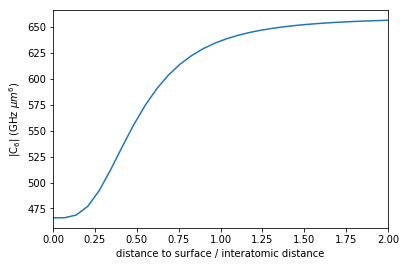

In [6]:
# Plot results
plt.plot(distance_surface / distance_atoms, np.abs(C6))
plt.xlim(min(distance_surface / distance_atoms), max(distance_surface / distance_atoms))
plt.xlabel("distance to surface / interatomic distance")
plt.ylabel(r"|C$_6$| (GHz $\mu m^6$)")
plt.show()